# Lab 1 : Spatial Autocorrelation

In [34]:
# We import our libraries here
library(spdep)
library(classInt)
library(rgdal)
library(RColorBrewer)
library(ggplot2)
library(dplyr)
library(broom)
library(sf)

Linking to GEOS 3.6.1, GDAL 2.1.3, proj.4 4.9.3


## Read in the data and take a look at it

Read the shape file from the data directory

In [54]:
auck <- readOGR("data/ak_TB_05.shp", integer64="allow.loss")

OGR data source with driver: ESRI Shapefile 
Source: "data/ak_TB_05.shp", layer: "ak_TB_05"
with 318 features
It has 14 fields
Integer64 fields read as signed 32-bit integers:  AU_NO TB_CASES TOT_06 EUR_06 MAO_06 PAC_06 ASI_06 MEL_06 OTH_06 


In [55]:
# Let's see a summary of our spatial data
summary(auck)

Object of class SpatialPolygonsDataFrame
Coordinates:
      min     max
x 2638999 2713900
y 6449610 6503050
Is projected: TRUE 
proj4string :
[+proj=nzmg +lat_0=-41 +lon_0=173 +x_0=2510000 +y_0=6023150
+datum=nzgd49 +units=m +no_defs +ellps=intl
+towgs84=59.47,-5.04,187.44,0.47,-0.1,1.024,-4.5993]
Data attributes:
    OBJECTID           AU_NAME      SHAPE_LENG       SHAPE_AREA       
 1      :  1   Abbotts Park:  1   Min.   :  2273   Min.   :   199484  
 10     :  1   Aberfeldy   :  1   1st Qu.:  5186   1st Qu.:  1063873  
 100    :  1   Akarana     :  1   Median :  6234   Median :  1501853  
 101    :  1   Albany      :  1   Mean   :  9148   Mean   :  4445327  
 102    :  1   Ambury      :  1   3rd Qu.:  8219   3rd Qu.:  2097003  
 103    :  1   Aorere      :  1   Max.   :142920   Max.   :204233182  
 (Other):312   (Other)     :312                                       
     AU_NO           TB_CASES          TOT_06         EUR_06    
 Min.   :506901   Min.   : 0.000   Min.   : 165   M

In [56]:
#names function gives you the header (first row) of your data
names(auck)

[1] "OBJECTID"   "AU_NAME"    "SHAPE_LENG" "SHAPE_AREA" "AU_NO"     
 [6] "TB_CASES"   "TOT_06"     "EUR_06"     "MAO_06"     "PAC_06"    
[11] "ASI_06"     "MEL_06"     "OTH_06"     "TB_RATE"

In [57]:
#The data frame -> row and header of data, in "tabular" format
#let's make df the dataframe
df <- data.frame(auck)
df

,OBJECTID,AU_NAME,SHAPE_LENG,SHAPE_AREA,AU_NO,TB_CASES,TOT_06,EUR_06,MAO_06,PAC_06,ASI_06,MEL_06,OTH_06,TB_RATE
0,1,North Harbour East,10497.337,5167324.5,508807,4,3693,2217,144,36,975,63,351,108.3
1,2,North Harbour West,12351.507,2882323.0,508806,1,2949,1704,141,30,810,57,291,33.9
2,3,Windsor Park,6603.966,2686065.0,508805,0,1800,1014,48,21,585,42,144,0.0
3,4,Half Moon Bay,5951.116,1249047.5,522730,2,3432,2283,147,54,684,42,354,58.3
4,5,Pinehill,5387.856,1634537.0,508804,0,2700,1173,60,33,1230,30,201,0.0
5,6,Herald,12571.814,1909593.0,513420,1,1698,1311,102,57,60,12,249,58.9
6,7,Unsworth Heights,6118.736,1809425.5,508803,1,5169,2646,297,147,1488,438,411,19.3
7,8,Otimai,19356.538,14988119.5,512902,0,2508,2037,150,30,36,15,267,0.0
8,9,Parrs Park,9899.108,3659348.0,512901,3,6198,3003,948,1620,813,93,354,48.4
9,10,Green Bay,7936.118,2169151.0,512100,4,3936,2811,318,249,405,27,405,101.6


In [43]:
#auck <- auck[,c(3,13)]
#auck

## Plotting the data on a map

### Using plot

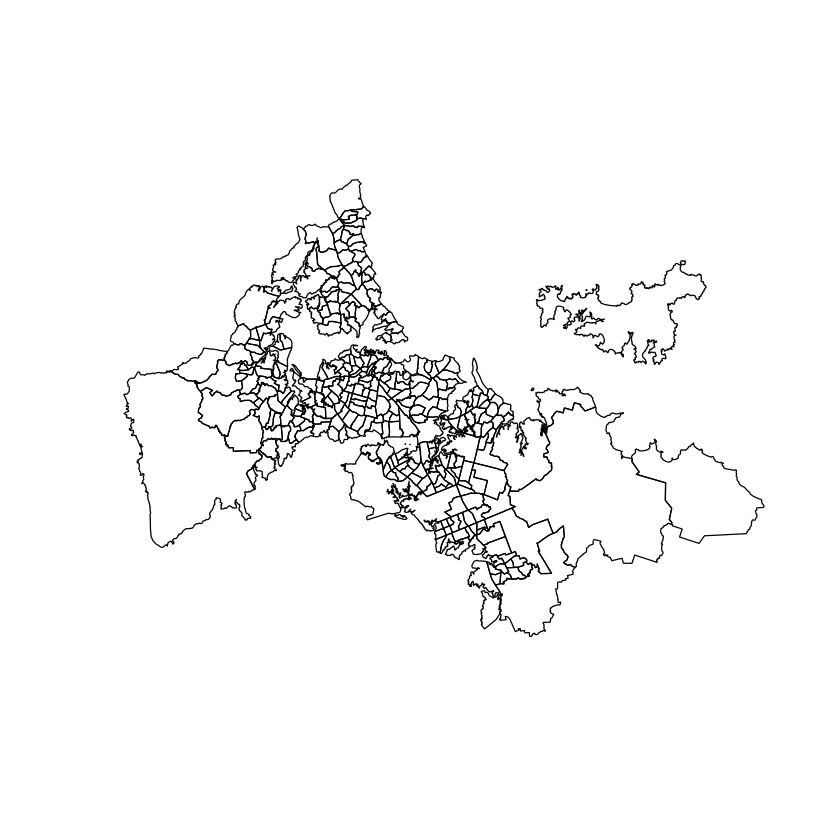

In [58]:
# Test plot the dataset using plot
plot(auck)

Note that the above has no color -- we need to add breaks 
to the data and do some extra work in plot to get color. Fortunately there are two libraries in R that do a lot of out of the box geospatial work

### Using spplot

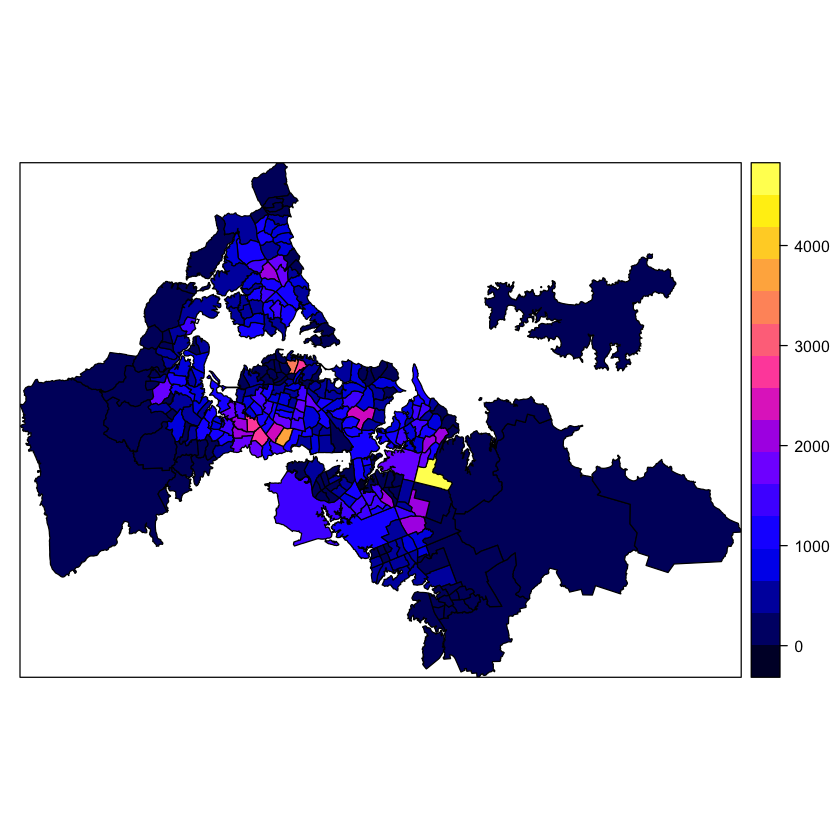

In [173]:
# We can also use spplot for this, a geospatial package for R
# spplot(data, column, legend settings)
spplot(auck, "ASI_06")

## Equal Intervals Map

In [176]:
## Definition of a function to automate a series of commands and make a choropleth map
choro <- function(sf, varname, nclasses=5, pal='Reds', sty='equal', ttl='') {
    palette <- brewer.pal(nclasses, pal)
    classes <- classIntervals(sf[[varname]], nclasses, style=sty)
    colors <- findColours(classes, palette)
    plot(sf, col=colors, lwd=0.35)
    legend('top', ncol=3, legend=names(attr(colors, 'table')), fill=attr(colors, 'palette'), cex=0.8, bty='n')
    title(ttl)
}

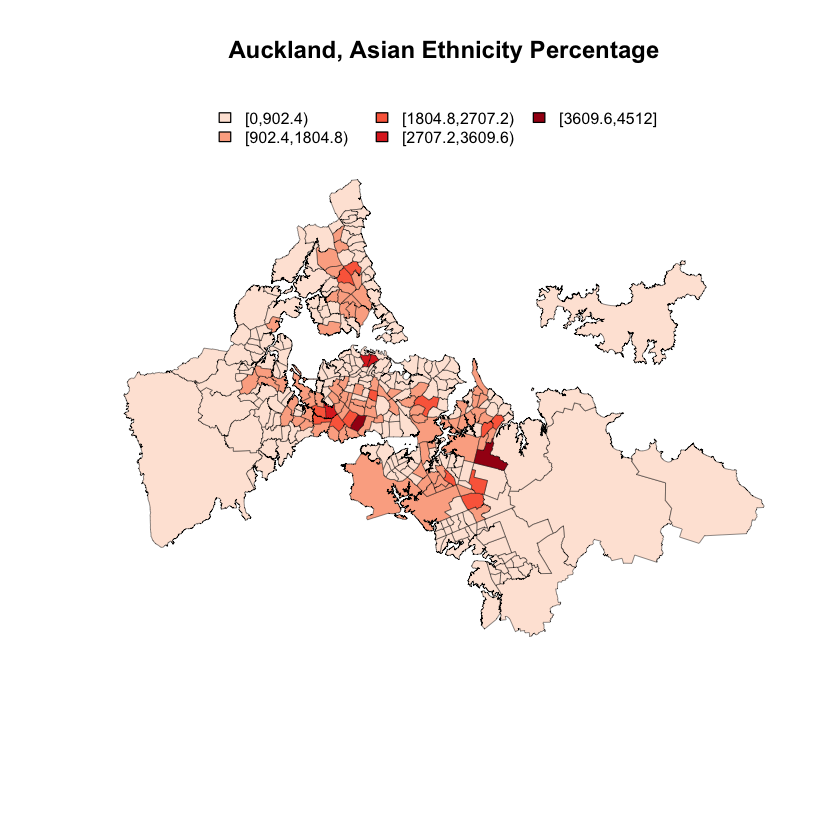

In [177]:
choro(auck, 'ASI_06', pal='Reds', nclasses=5, sty='equal', ttl='Auckland, Asian Ethnicity Percentage')

## Standard Deviations Map

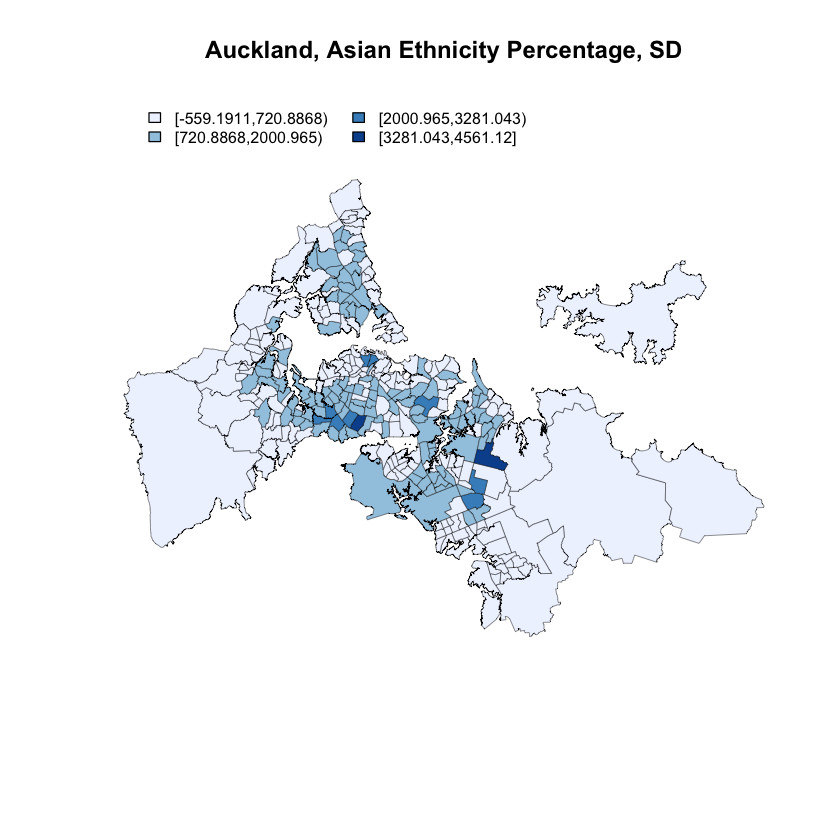

In [178]:
choro(auck, 'ASI_06', pal='Blues', nclasses=5, sty='sd', ttl='Auckland, Asian Ethnicity Percentage, SD')

## Quantiles Map

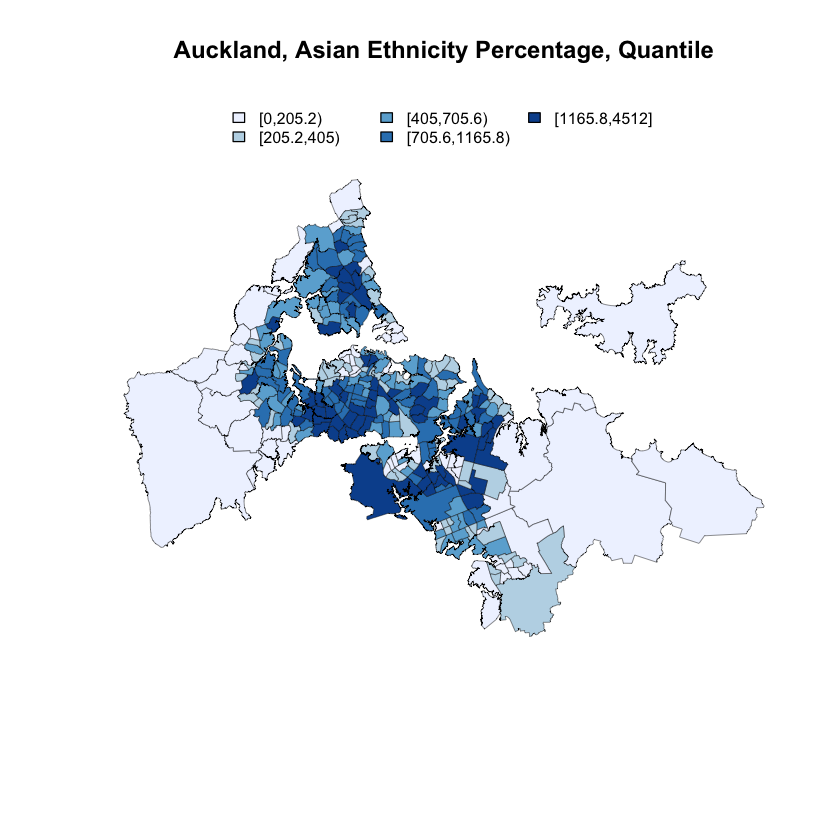

In [179]:
choro(auck, 'ASI_06', pal='Blues', nclasses=5, sty='quantile', ttl='Auckland, Asian Ethnicity Percentage, Quantile')

## Natural Breaks (Jenks) map

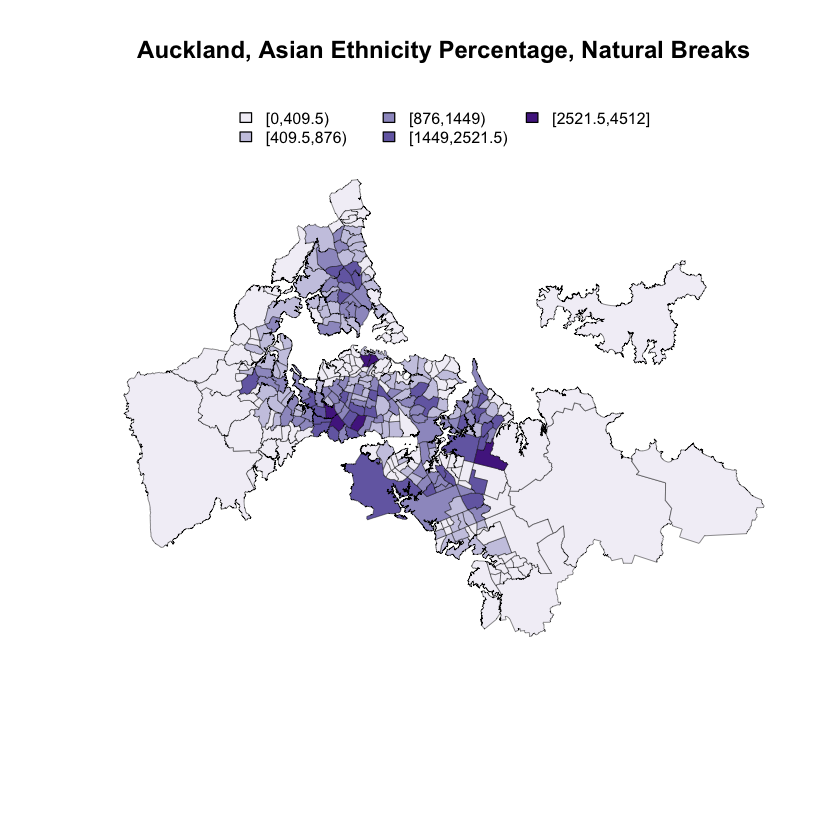

In [180]:
choro(auck, 'ASI_06', pal='Purples', nclasses=5, sty='fisher', ttl='Auckland, Asian Ethnicity Percentage, Natural Breaks')

# Graphing the data

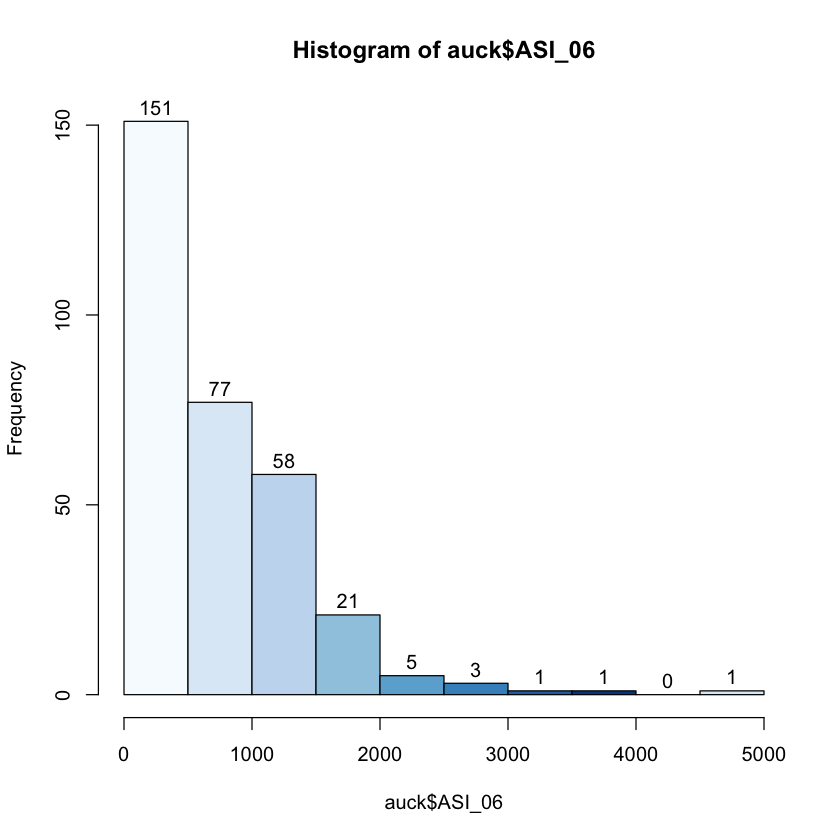

In [181]:

hist(auck$ASI_06, labels=T ,col=pal)

# Spatial autocorrelation

In [182]:
# Generate the weight matrix
# queen = False option means at least two boundary points must be 
# within the snap distance of each other
# with the conventional name of a ‘rook’ relationship.
# The snap option is the same as precision threshold in geoda

nb <- poly2nb(auck, row.names=auck$FIRST_CAU_, queen=FALSE, snap=1e-05)
length(nb)


[1] 318

In [183]:
#example of the first polygon in w, numbers are the neighbors for the first polygon
nb[1]
auck$FIRST_CAU_[1]

#make a summary of w
summary(nb)

[[1]]
[1]   2   3   5   7 146 154

NULL

Neighbour list object:
Number of regions: 318 
Number of nonzero links: 1488 
Percentage nonzero weights: 1.471461 
Average number of links: 4.679245 
1 region with no links:
131
Link number distribution:

 0  1  2  3  4  5  6  7  8  9 11 12 
 1  6 21 40 83 79 51 19 13  3  1  1 
6 least connected regions:
5 40 74 207 213 270 with 1 link
1 most connected region:
303 with 12 links


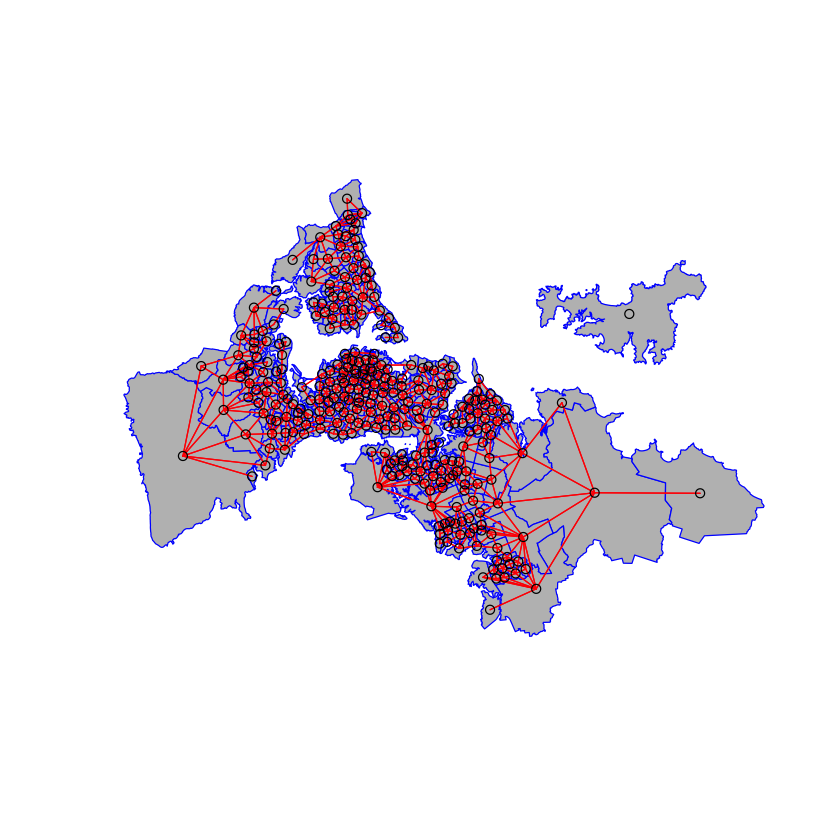

In [184]:
plot(auck, col='gray', border='blue', lwd=1)
xy <- coordinates(auck)
plot(nb, xy, col='red', lwd=1, add=TRUE)

In [185]:
#style = B indicates show the weights as binaries (0 or 1)
# wm <- nb2mat(nb, style='B', zero.policy=TRUE)

In [167]:
#this is what the first few rows of the weights matrix looks like, 
# since we set style=B, values are either 0 or 1 
# head(wm)

## Moran's *I* in equation form

$I = \frac{n}{\sum_{i=1}^n (y_i - \bar{y})^2} \frac{\sum_{i=1}^n \sum_{j=1}^n w_{ij}(y_i - \bar{y})(y_j - \bar{y})}{\sum_{i=1}^n \sum_{j=1}^n w_{ij}}$

In [160]:
# Let's first see what manual computation of Moran's I looks like

#n is the number of observations (length of our dataset)
# n <- length(auck)

#we set y to the column of PC_ASIAN, then we get the mean.
# y <- auck$PC_ASIAN
# ybar <- mean(y)

#find the difference between y and ybar(the mean)
# dy <- y - ybar
# yi <- rep(dy, each=n)
# yj <- rep(dy)
# yiyj <- yi * yj

# pm <- matrix(yiyj, ncol=n)

# pmw <- pm * wm

# spmw <- sum(pmw)

# smw <- sum(wm)
# sw  <- spmw / smw
# vr <- n / sum(dy^2)
# MI <- vr * sw

#Morans I
# cat("Moran's I is", MI)

In [258]:
# let's make a weights object so that we 
# can use it with a less manual way of computing moran's i
lw <- nb2listw(nb, style="W", zero.policy=TRUE)

In [259]:
summary(lw, zero.policy=TRUE)

Characteristics of weights list object:
Neighbour list object:
Number of regions: 318 
Number of nonzero links: 1488 
Percentage nonzero weights: 1.471461 
Average number of links: 4.679245 
1 region with no links:
131
Link number distribution:

 0  1  2  3  4  5  6  7  8  9 11 12 
 1  6 21 40 83 79 51 19 13  3  1  1 
6 least connected regions:
5 40 74 207 213 270 with 1 link
1 most connected region:
303 with 12 links

Weights style: W 
Weights constants summary:
    n     nn  S0       S1       S2
W 317 100489 317 148.8196 1313.621


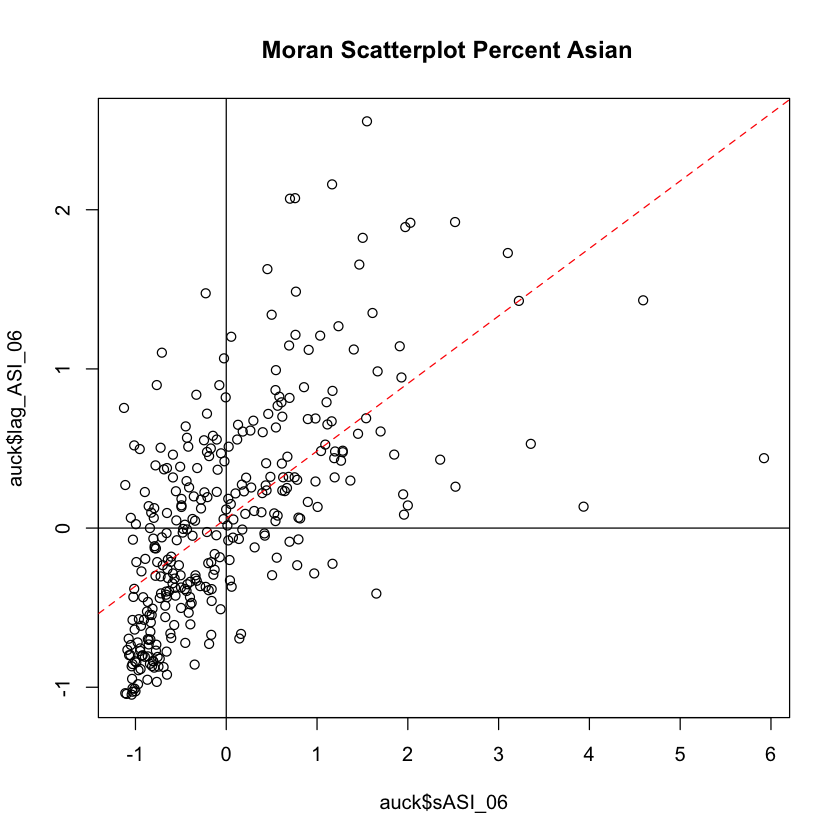

In [261]:
auck$sASI_06 <- scale(auck$ASI_06) 

auck$lag_ASI_06 <- lag.listw(lw, auck$sASI_06,zero.policy=TRUE)

plot(x=auck$sASI_06, y=auck$lag_ASI_06, main = " Moran Scatterplot Percent Asian")
abline(h=0, v=0)
best_fit_line <- lm(auck$lag_ASI_06 ~ auck$sASI_06)
abline(best_fit_line, lty=2, lwd=1, col="red")
#auck$lag_ASI_06

#Note that the slope of the regression line is nearly the same as Moran's I
#coefficients(best_fit_line)[2]


In [262]:
moran(auck$ASI_06, lw, n=length(lw$neighbours), S0=Szero(lw))

Warning message in lag.listw(listw, z, zero.policy = zero.policy, NAOK = NAOK):
“NAs in lagged values”

$I
[1] NA

$K
[1] 8.380946

In [243]:
moran.test(auck$ASI_06, lw, randomisation=FALSE, zero.policy=TRUE)


	Moran I test under normality

data:  auck$ASI_06  
weights: lw  

Moran I statistic standard deviate = 11.187, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.424226136      -0.003164557       0.001459571 


In [244]:
mmc <- moran.mc(auck$ASI_06, lw, nsim=999, zero.policy=TRUE)

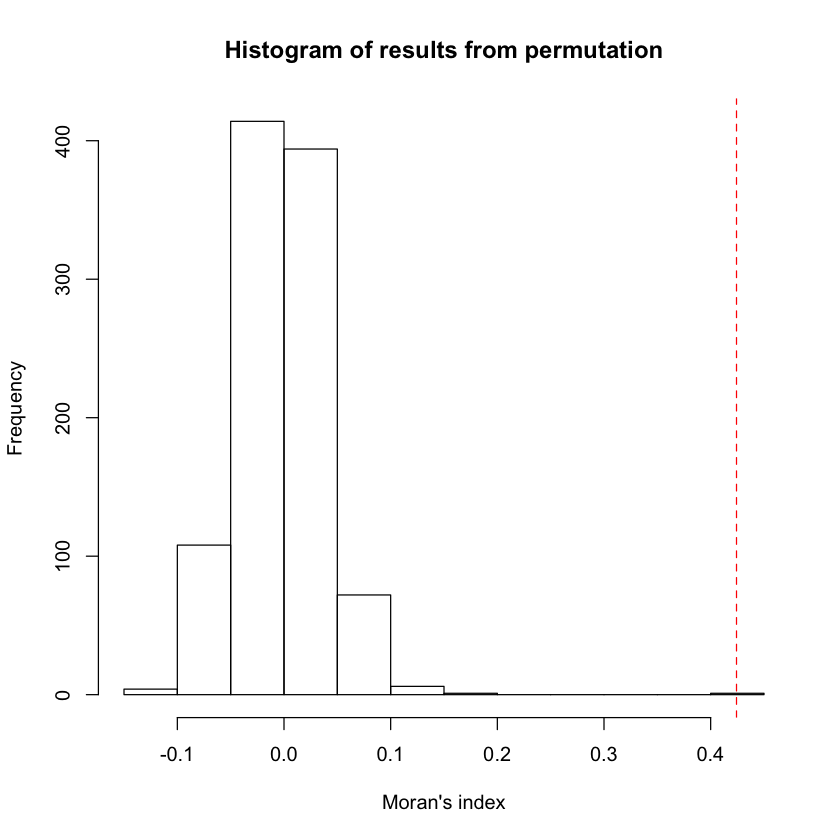

In [245]:
hist(mmc$res, main="Histogram of results from permutation", xlab="Moran's index")
abline(v=mmc$statistic, col='red', lty=2)

# Univariate Local Moran’s I

In [162]:
# We use the localmoran function instead of moran
locm <- localmoran(auck$PC_ASIAN, lw)
summary(locm)

ERROR: Error: is.vector(x) is not TRUE


In [ ]:
auck$sLPC_ASIAN <- scale(auck$PC_ASIAN) 

auck$lag_LPC_ASIAN <- lag.listw(lw, auck$sLPC_ASIAN,zero.policy=TRUE)

plot(x = auck$sLPC_ASIAN, y = auck$lag_LPC_ASIAN, main = "Local Moran Scatterplot PC_ASIAN")
abline(h = 0, v = 0)
abline(lm(auck$lag_LPC_ASIAN ~ auck$sLPC_ASIAN), lty = 2, lwd = 1, col = "red")

#Note that the slope of the regression line is nearly the same as Moran's I
slope <- lm(auck$lag_LPC_ASIAN ~ auck$sLPC_ASIAN)
coefficients(slope)[2]


In [ ]:
sig <- 0.001
# identify the moran plot quadrant for each observation to make the cluster map
auck$QUAD_SIG <- NA
auck$QUAD_SIG[(auck$sLPC_ASIAN >= 0 & auck$lag_LPC_ASIAN >= 0) & (locm[, 5] <= sig)] <- 1
auck$QUAD_SIG[(auck$sLPC_ASIAN <= 0 & auck$lag_LPC_ASIAN <= 0) & (locm[, 5] <= sig)] <- 2
auck$QUAD_SIG[(auck$sLPC_ASIAN >= 0 & auck$lag_LPC_ASIAN <= 0) & (locm[, 5] <= sig)] <- 3
auck$QUAD_SIG[(auck$sLPC_ASIAN <= 0 & auck$lag_LPC_ASIAN >= 0) & (locm[, 5] <= sig)] <- 4
auck$QUAD_SIG[(locm[, 5] > sig)] <- 5  
#5 are non significant observations

In [ ]:
# Set the breaks for the thematic map classes
# We use the seq function to generation a sequence from 1-5, going up by 1.
# you could also use 
breaks <- 1:6

# Set the corresponding labels for the thematic map classes
labels <- c("High-High", "Low-Low", "High-Low", "Low-High", "Not Signif.")

# Define color swatches
pal <- c("red", "blue", "lightpink", "skyblue2", "white")

# Generate the map
spplot(auck, "QUAD_SIG", at=breaks, col.regions=pal, main=list(label="Local Moran's I, LISA Cluster Map",cex=1))